# Question

In Titanic Data, it contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. In next cell, there are detail description of data from the source. My fundamental question have started from the survivors. Based on the survival data and each variable, the observation will be focused on the correlation of each factor, and how each variable has had affected the chance of survival in the incident. Specifically, variables such as ticket class, sex, age, and onboard family relationship are being analyzed in terms of survival. 

# Data Description


### Data Dictionary (Variable, Definition, Key)

| Variable   | Definition                                  | Key                                              |
|------------|---------------------------------------------|--------------------------------------------------|
| survival   | Survival                                    | 0 = No, 1 = Yes                                  |
| pclass     | Ticket class                                | 1 = 1st, 2 = 2nd, 3 = 3rd                        |
| sex        | Sex                                         |                                                  |
| Age        | Age in years                                |                                                  |
| sibsp      | # of siblings / spouses around the Titanic  |                                                  |
| parch      | # of parents / children aboard the Titanic  |                                                  |
| ticket     | Ticket number                               |                                                  |
| fare       | Passenger fare                              |                                                  |
| cabin      | Cabin number                                |                                                  |
| embarked   | Port of Embarkation                         | C = Cherbourg, Q = Queenstown, S = Southampton   |

### Variable Notes
- pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower

- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- sibsp: The dataset defines family relations in this way...
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: The dataset defines family relations in this way...
    - Parent = mother, father
    - Child = daughter, son, stepdaughter, stepson
        - Some children travelled only with a nanny, therefore parch=0 for them.

Source From: https://www.kaggle.com/c/titanic/data

# Data Wrangle

In [1]:
##Import pandas, numpy, matplotlib, seaborn, patches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
#Root file location
filename = 'titanic-data.csv'

#Retrieve csv file location and read csv file as Dataframe
raw_df = pd.read_csv(filename)

#Create a new dataframe with necessary information from the dataset
titanic_df = pd.DataFrame({
    'Ticket_Class': raw_df['Pclass'].values,
    'Survived': raw_df['Survived'].values
}, index=raw_df['PassengerId'])

#Check the total of rows to match 891 passengers
print(titanic_df.count())

Survived        891
Ticket_Class    891
dtype: int64


### Exploring Survivors with Ticket Classes

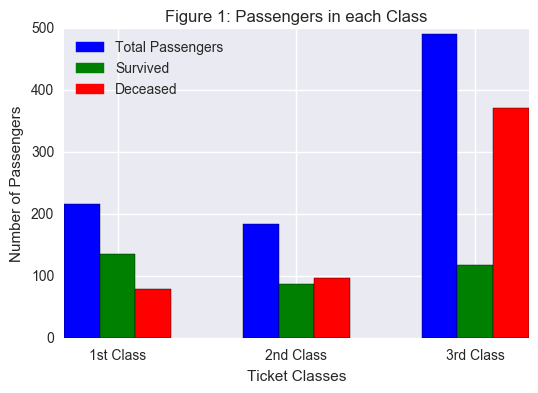

In [3]:
%matplotlib inline

#Group the data by the specific column and return the count of the dataset
#Make a list based on that new grouped data for plotting
total_by_classes = titanic_df.groupby('Ticket_Class').count()
temp1 = list(total_by_classes.values.flatten())

#Group the data by the specific column and return the count of the filtered dataset
#Make a list based on that new grouped data for plotting
survived_by_classes = titanic_df[titanic_df.Survived == 1].groupby('Ticket_Class').count()
temp2 = list(survived_by_classes.values.flatten())

#Group the data by the specific column and return the count of the filtered dataset
#Make a list based on that new grouped data for plotting
deceased_by_classes = titanic_df[titanic_df.Survived == 0].groupby('Ticket_Class').count()
temp3 = list(deceased_by_classes.values.flatten())

#Plot the bar graph
xaxis = np.array([1, 2, 3]) #number of axis
plt.xlabel('Ticket Classes')  #X-axis label
plt.ylabel('Number of Passengers') #Y-axis label
plt.title("Figure 1: Passengers in each Class") #Chart title
plt.xticks([1,2,3], ['1st Class', '2nd Class', '3rd Class']) #Rename the X-axis

#Divide the current figure into an m-by-n grid
#Plot the graph based on each list above
ax = plt.subplot(111)
ax.bar(xaxis-0.2, temp1, width=0.2, color ='b', align='center')
ax.bar(xaxis, temp2, width=0.2, color ='g', align='center')
ax.bar(xaxis+0.2, temp3, width=0.2, color ='r', align='center')

#Insert legend with color coding for information
blue_patch = mpatches.Patch(color='blue', label='Total Passengers')
green_patch = mpatches.Patch(color='green', label='Survived')
red_patch = mpatches.Patch(color='red', label='Deceased')
plt.legend(loc = 'upper left', handles=[blue_patch, green_patch, red_patch])

#Show the graph
plt.show()

In [4]:
#Combine pre-existing table into a single table
concat_tables_classes = pd.concat([total_by_classes, survived_by_classes, deceased_by_classes], axis=1)
concat_tables_classes.columns = ['Total Passengers', 'Survived', 'Deceased']
print(concat_tables_classes)

#Define a function to convert a series to percentages
def convert_percent(series):
    return round((series / series.iloc[0]) * 100, 2)

#Apply a function to each row
df_classes_survival_ratio = concat_tables_classes.apply(convert_percent, axis = 1)
print(df_classes_survival_ratio)

              Total Passengers  Survived  Deceased
Ticket_Class                                      
1                          216       136        80
2                          184        87        97
3                          491       119       372
              Total Passengers  Survived  Deceased
Ticket_Class                                      
1                        100.0     62.96     37.04
2                        100.0     47.28     52.72
3                        100.0     24.24     75.76


### Observations from Different Ticket Classes

Based on Figure 1 above, there are some noticeable observations related to ticket classes and survivor rates. More than half of passengers in the 1st class have survived from the incident. Compared to that, 3rd class passengers have shown much less survival rate compared to the first class. Also, red bar graphs that indicate the rate of deceased have shown a gradual increase as the ticket class changed from the 1st to 3rd. The percentages in the data frame proves this tendency (in df_classes_survival_ratio). 

Throughout the research, I have found different ways of performing statics tests in binary or categorical outcomes with proportions(in this case survival rate). According to Stanford University HRP258: Introduction to Probability and Statistics for Clinical Research by Kristin Sainani, it introduces several different ways such as Chi-square test, McNemar's chi-square, Relative risks, or Conditional logistic. Based on the decision tree in the lecture slides, my data seems to be independent result from three different groups(Ticket Classes). Furthermore, my data indicates different survival rates in different classes, so it fits the main purpose of chi-square test comparing proportions among three groups. 

Source From: 
1. web.stanford.edu/~kcobb/hrp258/lecture7.ppt
2. https://en.wikipedia.org/wiki/Chi-squared_test
3. https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test

#### Chi-Square Test
- To perform chi-square test, the overall survival rate should be calculated with all passengers of 891.

In [5]:
#Apply a function to each column
sum_classes_df = concat_tables_classes.apply(sum, axis=0)

#Get the total values for each series to find overall rate
total_passengers, survivors, deceased = sum_classes_df.iloc[0], sum_classes_df.iloc[1], sum_classes_df.iloc[2] 
overall_survival_rate = round(survivors / total_passengers, 2)
overall_deceased_rate = round(deceased / total_passengers, 2)

Before calculating chi-square as below, there should be some pre-works done such as calculating degree of freedom, and making hypothesis statements within the significance level.
$$\chi_{df}^2 = \sum \frac{(observed-expected)^2}{expected}$$


- Degree of Freedom: Since the data set has three rows and two columns as below, the degree of freedom should be 2. 
    $$(number\_ of\_rows - 1)*(number\_of\_columns -1) = (3-1)*(2-1)=2$$

| Ticket_Class | Deceased   | Survived   |
|--------------|------------|------------|
| 1.0          | 80         | 136        |
| 2.0          | 97         | 87         |
| 3.0          | 372        | 119        |

With the degree of freedom, I need to find the critical value at 95% significance level. Based on the chi-square distribution table, the upper-tail critical values gives the value of 5.99 at 95% significance level. 

<img src="chi_sqaure_distribution_table.PNG" />

These are my hypothesis for the chi-squared test;

- $H_0:$ The average survival rate of whole dataset (38%) will be similarly applied in different ticket classes respectively at 95% significance level. In other words, the difference in survival rates in each ticket class comparing with all passengers survival rate is not significantly different, but actually staying within the confidence intervals of whole passengers survival rate.


- $H_A:$ The alternative hypothesis is the average survival rate of each ticket class will be different from the whole passengers survival rate at 95% significance level. In this case, the difference in survival rates in each class comparing with all passengers survival rate is significantly different. Hence, the causation of different ticket classes can affect the survival rate can be assumed. 

Source From: http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG

In [6]:
#Define a function to calculate chi_square
def chi_square(row):
    total, survivor, deceased = map(lambda x: x, row)
    sur = ((survivor - (total * 0.38))**2) / (total * 0.38)
    dec = ((deceased - (total * 0.62))**2) / (total * 0.62)
    return sur + dec

#Apply a function to each row
df_chi_square = concat_tables_classes.apply(chi_square, axis = 1)
print(df_chi_square)
print("\nThe sum of chi-squared test:", round(df_chi_square.sum(),2))


Ticket_Class
1    57.130856
2     6.729497
3    39.480223
dtype: float64

The sum of chi-squared test: 103.34


### Finding from Survivors & Ticket Classes

As a result, the sum of chi-squared test is 103.34 which is much greater than the upper-tail critical value 5.99 at 95% significance level. Therefore, it rejects the null hypothesis, so the the average survival rate of each ticket class will be significantly different from the whole passengers survival rate at 95% significance level. Based on this test result, three different ticket classes can cause different survival rate in the incident. In this case, the rate of survival tends to increase as the ticket class goes up from the thrid to first.

Perform with the sex
perform with the age
perform with the onboard family relationship(sib/parch)

Based on the highest realtionship, Now I group them up with it then run the stat test.
Provide heuristic and compare that with the real survival rate.


Sex

In [7]:
#Create a new dataframe with necessary information from the dataset
titanic_sex_df = pd.DataFrame({
    'Sex': raw_df['Sex'].values,
    'Survived': raw_df['Survived'].values
}, index=raw_df['PassengerId'])

#Check the total of rows to match 891 passengers
print(titanic_sex_df.count())


Sex         891
Survived    891
dtype: int64


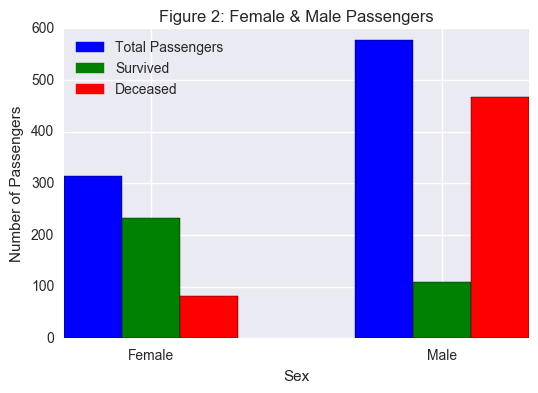

In [33]:
%matplotlib inline

#Group the data by the specific column and return the count of the dataset
#Make a list based on that new grouped data for plotting
total_by_sex = titanic_sex_df.groupby('Sex').count()
temp1 = list(total_by_sex.values.flatten())

#Group the data by the specific column and return the count of the filtered dataset
#Make a list based on that new grouped data for plotting
survived_by_sex = titanic_sex_df[titanic_sex_df.Survived == 1].groupby('Sex').count()
temp2 = list(survived_by_sex.values.flatten())

#Group the data by the specific column and return the count of the filtered dataset
#Make a list based on that new grouped data for plotting
deceased_by_sex = titanic_sex_df[titanic_sex_df.Survived == 0].groupby('Sex').count()
temp3 = list(deceased_by_sex.values.flatten())

#Plot the bar graph
xaxis = np.array([1, 2]) #number of axis
plt.xlabel('Sex')  #X-axis label
plt.ylabel('Number of Passengers') #Y-axis label
plt.title("Figure 2: Female & Male Passengers") #Chart title
plt.xticks([1,2,3], ['Female', 'Male']) #Rename the X-axis

#Divide the current figure into an m-by-n grid
#Plot the graph based on each list above
ax = plt.subplot(111)
ax.bar(xaxis-0.2, temp1, width=0.2, color ='b', align='center')
ax.bar(xaxis, temp2, width=0.2, color ='g', align='center')
ax.bar(xaxis+0.2, temp3, width=0.2, color ='r', align='center')

#Insert legend with color coding for information
blue_patch = mpatches.Patch(color='blue', label='Total Passengers')
green_patch = mpatches.Patch(color='green', label='Survived')
red_patch = mpatches.Patch(color='red', label='Deceased')
plt.legend(loc = 'upper left', handles=[blue_patch, green_patch, red_patch])

#Show the graph
plt.show()


In [10]:
#Combine pre-existing table into a single table
concat_tables_sex = pd.concat([total_by_sex, survived_by_sex, deceased_by_sex], axis=1)
concat_tables_sex.columns = ['Total Passengers', 'Survived', 'Deceased']
print(concat_tables_sex)

#Apply a function to each row
df_sex_survival_ratio = concat_tables_sex.apply(convert_percent, axis = 1)
print(df_sex_survival_ratio)


        Total Passengers  Survived  Deceased
Sex                                         
female               314       233        81
male                 577       109       468
        Total Passengers  Survived  Deceased
Sex                                         
female             100.0     74.20     25.80
male               100.0     18.89     81.11


In [11]:
#Define a function to calculate chi_square
def chi_square(row):
    total, survivor, deceased = map(lambda x: x, row)
    sur = ((survivor - (total * 0.38))**2) / (total * 0.38)
    dec = ((deceased - (total * 0.62))**2) / (total * 0.62)
    return sur + dec

#Apply a function to each row
df_chi_square_sex = concat_tables_sex.apply(chi_square, axis = 1)
print(df_chi_square_sex)
print("\nThe sum of chi-squared test:", round(df_chi_square_sex.sum(),2))

Sex
female    174.688049
male       89.430339
dtype: float64

The sum of chi-squared test: 264.12


Age

In [12]:
#Create a new dataframe with necessary information from the dataset
titanic_age_df = pd.DataFrame({
    'Age': raw_df['Age'].values,
    'Survived': raw_df['Survived'].values
}, index=raw_df['PassengerId'])

#Check the total of rows to match 891 passengers
print(titanic_age_df.count())

Age         714
Survived    891
dtype: int64


In [44]:
%matplotlib inline

#Group the data by the specific column and return the count of the dataset
#Make a list based on that new grouped data for plotting
titanic_age_range_df = titanic_age_df.groupby(pd.cut(titanic_age_df['Age'], range(0, 100, 10))).count()
#print(titanic_age_range_df)

age_total_by_range = titanic_age_range_df['Age'].values
temp1 = list(age_total_by_range)

#Group the data by the specific column and return the count of the filtered dataset
#Make a list based on that new grouped data for plotting
survived_filtered = titanic_age_df[titanic_age_df.Survived == 1]
print(survived_filtered.count())
#survived_by_sex = titanic_sex_df[titanic_sex_df.Survived == 1].groupby('Sex').count()
#temp2 = list(survived_by_sex.values.flatten())

deceased_filtered = titanic_age_df[titanic_age_df.Survived == 0]
print(deceased_filtered.count())

Age         290
Survived    342
dtype: int64
Age         424
Survived    549
dtype: int64


Onboard - sib

In [13]:
titanic_sibsp_df = pd.DataFrame({
    'SibSp': raw_df['SibSp'].values,
    'Survived': raw_df['Survived'].values
}, index=raw_df['PassengerId'])

#Check the total of rows to match 891 passengers
print(titanic_sibsp_df.count())

SibSp       891
Survived    891
dtype: int64


Onboard - parch

In [14]:
titanic_parch_df = pd.DataFrame({
    'Parch': raw_df['Parch'].values,
    'Survived': raw_df['Survived'].values
}, index=raw_df['PassengerId'])

#Check the total of rows to match 891 passengers
print(titanic_parch_df.count())


Parch       891
Survived    891
dtype: int64
